In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors as colors
import matplotlib.patches as patches

import math
import json
import numpy as np

import ACClasses

import helpers
import os
from datetime import datetime

# Basic Design Considerations : XLZD 
* TPC Radius~Height = 298cm  


* Electric Field : Between 240 and 290 V/cm  
* The extraction field 6-8kV/cm
* Base_Model : 60t  
* Charge-insensitive mass below the cathode : 10cm  
* LXe skin : 7 cm  
(extra 30 cm below the photocathodes of the bottom
photosensor array)   
* 3 inch PMT Array : 1182 PMTS Top array and same for bottom.  
* PMTs average quantum effciency : 34% at 20C (at a
average internal photo electron collection effciency of 90%.)
* Electron life_time : 10ms or better 




# Params Used in FD And Pranati's code :

* Drift field : 80 V/cm in FD v/s 200V/cm in Pranati's
> Why so less ?

* Extraction Field : 7.5 kV/cm

* g1 : 0.27 
> Acc to ROB it's PMT q.effciency  
> In Pranati's code, it's calculated via a formula :  PMTDetectionProb*(LCETop + LCEBottom)/2, where PMTDetProb is the avg PMT quantum efficiency as described in comments : ACCClasses.py)


* g2 : 44.65305146945426
> Is calculated via a fn in parameter_calc.py in fd  

* Extraction Efficiency : 0.93 at 160K and 7.5kV/cm Extraction Field
> Is calc via fn parameter_calc.py  
> It is higher ~0.94 for 8kV/cm
* electron_lifetime : 10ms 
> User input 

* Extraction Efficiency :  0.8993482035526084
> Calc via a fn in parameter_calc.py in fd  
> User input in Pranati's code 

# Function to print LY and CY

In [48]:
"""
print(ACClasses.ReadNest("ER",10,"electrons",200))
print(ACClasses.ReadNest("ER",10,"photons",200))
print(ACClasses.ReadNest("NR",40,"electrons",200))
print(ACClasses.ReadNest("NR",40,"photons",200))
print("The electron drift speed is", f'{ACClasses.fElectronDriftSpeed(200)} mm/mus for 200V/cm')
print("The Active LXe volume is  ", f'{ACClasses.fToMass(300,300)} Tonnes')
"""

'\nprint(ACClasses.ReadNest("ER",10,"electrons",200))\nprint(ACClasses.ReadNest("ER",10,"photons",200))\nprint(ACClasses.ReadNest("NR",40,"electrons",200))\nprint(ACClasses.ReadNest("NR",40,"photons",200))\nprint("The electron drift speed is", f\'{ACClasses.fElectronDriftSpeed(200)} mm/mus for 200V/cm\')\nprint("The Active LXe volume is  ", f\'{ACClasses.fToMass(300,300)} Tonnes\')\n'

# Scaling for XLZD

In [49]:
"""
# We calc the surface area of the detector here, to be used later when specifying detector config.
radius=298/2
Area_XLZD60t_lid = radius*radius*np.pi  # in cm^2
Area_XLZD60t= 2*Area_XLZD60t_lid+np.pi*radius * radius #in cm^2

# Since the OG code for whatever reasons uses XENON1T as a variable name in many places like Particle background, it's easier to switch our XLZD variable to XENON, for convenience sake : 
Area_Xenon1t_lid=Area_XLZD60t_lid 
Area_Xenon1t=Area_XLZD60t

# Not sure what this is ? 


"""

"\n# We calc the surface area of the detector here, to be used later when specifying detector config.\nradius=298/2\nArea_XLZD60t_lid = radius*radius*np.pi  # in cm^2\nArea_XLZD60t= 2*Area_XLZD60t_lid+np.pi*radius * radius #in cm^2\n\n# Since the OG code for whatever reasons uses XENON1T as a variable name in many places like Particle background, it's easier to switch our XLZD variable to XENON, for convenience sake : \nArea_Xenon1t_lid=Area_XLZD60t_lid \nArea_Xenon1t=Area_XLZD60t\n\n# Not sure what this is ? \n\n\n"

In [50]:
Area_Xenon1t_lid = 48.*48.*np.pi  # cm^2
Area_Xenon1t = Area_Xenon1t_lid + np.pi*2.*48. * 100.
Area_LZPTFE = np.pi*2.*75. * 150. #cm^2 

Set up our detector

In [51]:
# Everything taken from design book : paste url, values in cm for height, radius etc..
XLZDdetector = ACClasses.Detector(TPCHeight=298.,  #396cm for 80t config
               TPCRadius = 298./2,
               BelowCathodeHeight = 10.,
               FiducialCut = 7.,
               ExtractionEfficiency = 0.90, # not mentioned in DB, using FD value, FD it depends upon temperature, either decrease temp or increase extraction field 
               g2 =  44.65305146945426,# g2 factor not mentioned for XLZD, using FD value,
               #g2 = 16,
               SEGain = 40, #important factor down the line, need to fix carefully
               LCETop = 0.26, # Input from Owen (Prelim)
               LCEBottom = 0.44, # Input from Owen (Prelim)
               g1=0.27,
               PMTDetectionProb = 0.34, # As mentioned in DB, 
               PMTDarkRate = 18, # it's 12-24 as mentioned in design book
               DriftField = 200,
               ElectronLifetime = 10, # not mentioned explictly, XLZD wants better than 10ms
               PMTDensity = 250./Area_Xenon1t_lid
                    )

detector= XLZDdetector
print(detector)

# Why is Rob using g1= 0.27 in FD for xlzd (he mentions it's "this represents PMT QE", even then it should be 0.34)?? 
# since LCE avg value per config is already mentioned XLZD.py, 0.49X0.34=0.16 it should be, for ref, LZ's g1 is 0.11


the fiducial mass is 54.16 tonnes
		the active mass is 59.63 tonnes
		the below-cathode mass is 2.00 tonnes
		the drift speed is 123.93cm/ms
		the max drift time is 2.40ms
		the number of PMTs is 2408 
		g1 is 0.27


In [52]:
"""
def fElectronDriftSpeed(DriftField):
	a = 0.2459
	b =	 -0.30527
	return a/np.power(DriftField,b)

Electron_Drift_speed=fElectronDriftSpeed(80)/1e4 # dividing by 1e4 to convert mm/us to cm/ns

print("Electron Drift speed Pranati :", f'{Electron_Drift_speed} cm/ns')
print("Electron Drift_speed Rob : 15.032655984517694e-05 cm/ns")
"""

'\ndef fElectronDriftSpeed(DriftField):\n\ta = 0.2459\n\tb =\t -0.30527\n\treturn a/np.power(DriftField,b)\n\nElectron_Drift_speed=fElectronDriftSpeed(80)/1e4 # dividing by 1e4 to convert mm/us to cm/ns\n\nprint("Electron Drift speed Pranati :", f\'{Electron_Drift_speed} cm/ns\')\nprint("Electron Drift_speed Rob : 15.032655984517694e-05 cm/ns")\n'

# Drift_time 

> to be calc from drift speed as distance/speed  
> Important quantity : Used in Prob of all electrons lost calc : $1-e^{-(t_{drift}/\tau_{elife})}$

In [53]:
"""
TPCHeight=298 #cm

MaxDriftTime = TPCHeight/Electron_Drift_speed     # ns 
print("The Max Drift Time is", f"{MaxDriftTime} ns or {MaxDriftTime*1e-6} ms")
"""

'\nTPCHeight=298 #cm\n\nMaxDriftTime = TPCHeight/Electron_Drift_speed     # ns \nprint("The Max Drift Time is", f"{MaxDriftTime} ns or {MaxDriftTime*1e-6} ms")\n'

# Backgrounds
As a first pass we are using the rates from XENON1t, will look into these numbers from FD workflow, however , they have been scaled appropriately for XLZD sized detector (again, the variable name suggests XENON1t, but that is only for convenience, the physical dimensions have been redefined for this variable in the very first block. )

# Particle Backgrounds 
* NR:
> CEvNS - modelled as a double exponential spectrum  
> Neutrons - modelled as a single exponential spectrum

* ER:
> Total ER rate in the relevant energy window where ~ < 200 photons are produced is approximately flat,so we model it as flat.  
> Individual contributions are not considered separately, only the sum spectrum.  



In [54]:
particleBackgroundsXENON1t = ACClasses.ParticleBackground(
        detector = detector,
        A1_cevns = 915, # NR background's CEvNS two exponentials. These come from a rough fit to the LZ background spectra
        b1_cevns = 0.5, # keV
        A2_cevns = 0.083, # events per (kev tonne year)
        b2_cevns = 16.7, # keV
        A_neutrons_fiducial = 0.005/Area_Xenon1t, # times 1 tonne to remove mass dependence Fig 8 in https://arxiv.org/pdf/1512.07501.pdf
        #A_neutrons_edge = 125 * 2.0/Area_Xenon1t, # times 2 tonnes to remove mass dependence
        A_neutrons_edge = 125 * 2.0/Area_Xenon1t, # times 2 tonnes to remove mass dependence
        b_neutrons = 25., # keV
        FlatERRate_internal = 10.0,  # events per (kev, tonne, year) prediction for nT,  # Rn, Kr - events per (kev tonne year)
        FlatErRate_external = 100./Area_Xenon1t,   #events per (kev * yr* cm^2) (not per mass), only close to the walls in 1-12 keV from 1T; from https://arxiv.org/pdf/1512.07501.pdf
                        )
particleBackgrounds = particleBackgroundsXENON1t
particleBackgrounds.FlatERRate_internal = particleBackgrounds.FlatERRate_internal/100.
particleBackgrounds.FlatErRate_external = particleBackgrounds.FlatErRate_external/100.

# Instrumental Backgrounds 

> Again the rates for lone S1 and S2 are derived from Xenon1T , but scaled for XLZD, how would we get these rates for xlzd ? Also, what are these variables exactly ? Need to look up some theory on ACs !

In [55]:
instrumentalBackgrounds1T = ACClasses.InstrumentalBackground(
        detector = detector,
        A_unexplainedLoneS2 = 20.*6e9/Area_Xenon1t/ACClasses.SecondsPerYear,  # /(yr cm^2); to match lone S2 rate reoprted in XENON1T above 8 PE
        b1_unexplainedLoneS2 = 0.3,  # to match lone S2 spectrum observed in XENON1T
        b2_unexplainedLoneS2 = 1.8,  # to match lone S2 spectrum observed in XENON1T
        r_unexplainedLoneS2 = 0.9999,  # to match lone S2 spectrum observed in XENON1T
        c_unexplainedLoneS2 = 20.*450/Area_Xenon1t/ACClasses.SecondsPerYear,  # to match lone S2 spectrum observed in XENON1T
        unexplainedLoneS1Rate = 30000./Area_LZPTFE, # # to match the lone S1 rate observed in XENON1T
        S1MisclassificationProb = 0.00003, # Probability to misclassify a signal from SE as an S1. This is a wild guess
        )
#settings
instrumentalBackgrounds = instrumentalBackgrounds1T


# Range for plotting in cS1, cS2 space 



In [56]:
# For migdal, cs1 projections peaked at 5 and cS2 at 10^(3.5)
energyRange = 15 # keV
maxS1Range = 250
maxS2Range = 200

# Plots 

* Electron Loss Probability : the probability that all electrons from an interaction are absorbed , well defined function for the same.

* Photon Loss probability : the probability that all photons from an interaction are absorbed  


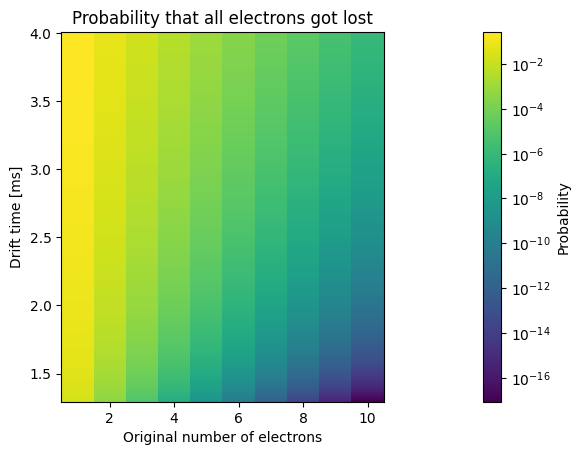

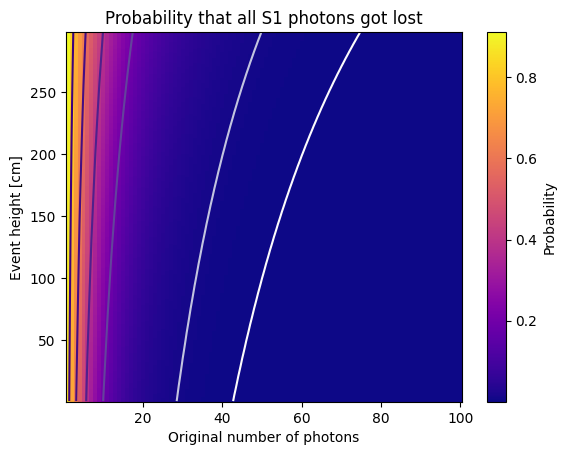

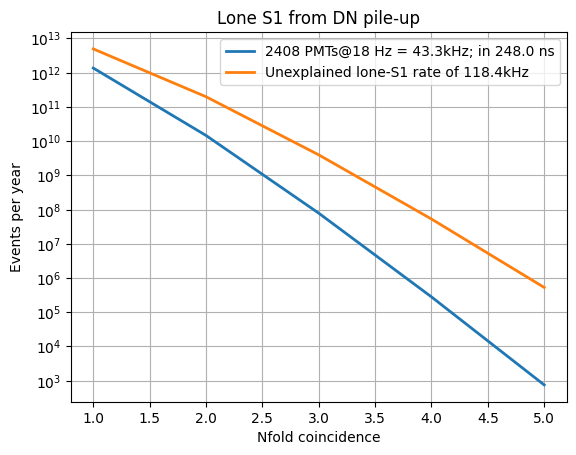

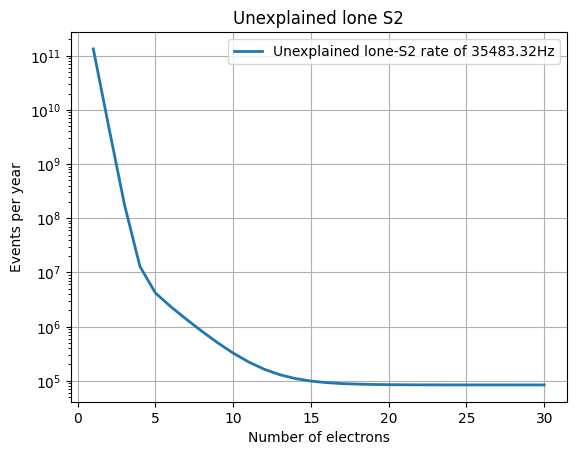

502801.9600228706
86747.51859502915
83944.16817153186
Lone S2 rate above 8 e-: 0.08617786138279752 Hz


In [57]:
# Loss Probability
instrumentalBackgrounds.PlotElectronLossProbability()
instrumentalBackgrounds.PhotonLossProbability()
instrumentalBackgrounds.PlotDarkNoiseRate()

loneS2perYear = 0.
for i in range(20):
    if i < 8:
        continue
    loneS2perYear = loneS2perYear + instrumentalBackgrounds.RUnexplainedS2(i)
print(instrumentalBackgrounds.RUnexplainedS2(9))
print(instrumentalBackgrounds.RUnexplainedS2(18))
print(instrumentalBackgrounds.RUnexplainedS2(27))
print("Lone S2 rate above 8 e-: " + str(loneS2perYear/ACClasses.SecondsPerYear) + " Hz")

# BG Event Rates - XLZD

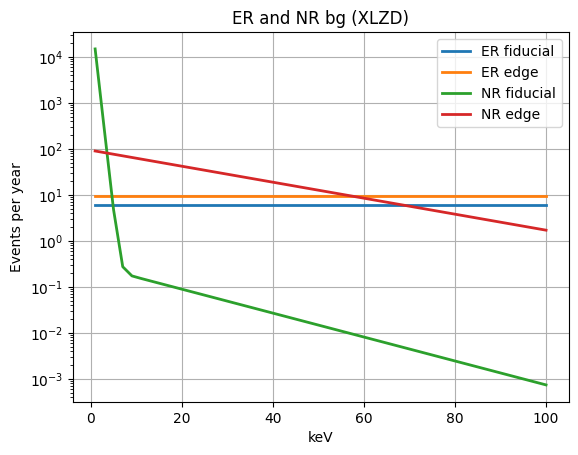

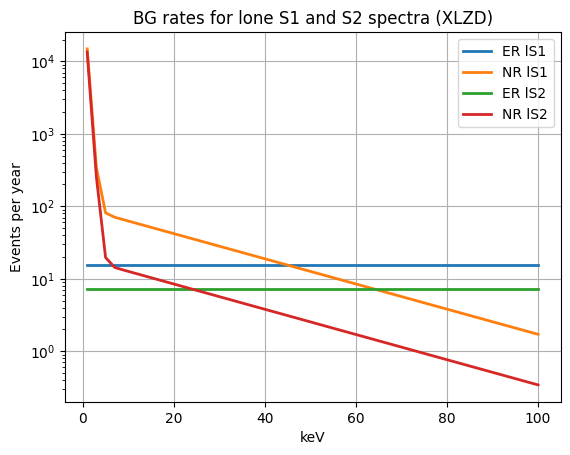

In [58]:
#Particle backgrounds

## In energy space

###This part is just to check that the energy spectra match whatever is expected from simulations
fig_bg, ax_bg = plt.subplots()
x_bg = np.linspace(1, 100, 50) #keV
y_bger_in = particleBackgrounds.BackgroundSpectrum(x_bg, "ER", "internal", detector.activeMass, -1)
y_bger_ex = particleBackgrounds.BackgroundSpectrum(x_bg, "ER", "external", -1, detector.TPCArea)

y_bgnr_in = particleBackgrounds.BackgroundSpectrum(x_bg, "NR", "internal", detector.activeMass, -1)
y_bgnr_ex = particleBackgrounds.BackgroundSpectrum(x_bg, "NR", "external", -1, detector.TPCArea)

ax_bg.semilogy(x_bg, y_bger_in, linewidth=2.0, label="ER fiducial")
ax_bg.semilogy(x_bg, y_bger_ex, linewidth=2.0, label="ER edge")
ax_bg.semilogy(x_bg, y_bgnr_in, linewidth=2.0, label="NR fiducial")
ax_bg.semilogy(x_bg, y_bgnr_ex, linewidth=2.0, label="NR edge")

ax_bg.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=25))
ax_bg.grid()
ax_bg.legend()
ax_bg.set_xlabel("keV")
ax_bg.set_ylabel("Events per year")
ax_bg.set_title("ER and NR bg (XLZD)")
plt.show()

## Now we collect those sources and detector locations that can create LS1 or LS2 signals
### Backgrounds relevant to lone-s1
y_bger_ls1 = particleBackgrounds.BackgroundSpectraForLone(x_bg, "S1", "ER")
y_bgnr_ls1 = particleBackgrounds.BackgroundSpectraForLone(x_bg, "S1", "NR")

### Backgrounds relevant to lone-s2
y_bger_ls2 = particleBackgrounds.BackgroundSpectraForLone(x_bg, "S2", "ER")
y_bgnr_ls2 = particleBackgrounds.BackgroundSpectraForLone(x_bg, "S2", "NR")

fig_bg2, ax_bg2 = plt.subplots()
ax_bg2.semilogy(x_bg, y_bger_ls1, linewidth=2.0, label="ER lS1")
ax_bg2.semilogy(x_bg, y_bgnr_ls1, linewidth=2.0, label="NR lS1")
ax_bg2.semilogy(x_bg, y_bger_ls2, linewidth=2.0, label="ER lS2")
ax_bg2.semilogy(x_bg, y_bgnr_ls2, linewidth=2.0, label="NR lS2")

ax_bg2.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=25))
ax_bg2.grid()
ax_bg2.legend()
ax_bg2.set_xlabel("keV")
ax_bg2.set_ylabel("Events per year")
ax_bg2.set_title("BG rates for lone S1 and S2 spectra (XLZD)")
plt.show()


Not Sure what/how this works ..

It may take a moment for the blurring to finish.
It may take a moment for the blurring to finish.


/var/folders/11/qrrzf16128s2xj54lz_vslsm0000gn/T/ipykernel_83062/2163998841.py:79: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 640x480 with 2 Axes> which fig.colorbar is called on.
  fig_xx.colorbar(im_xxx, ax=ax_xxx, pad=0.05, label="Rate")


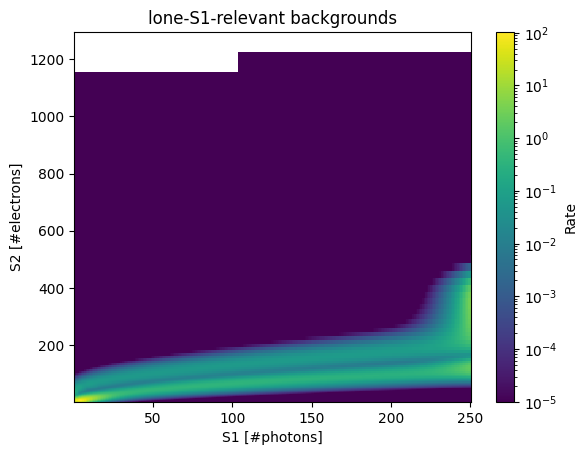

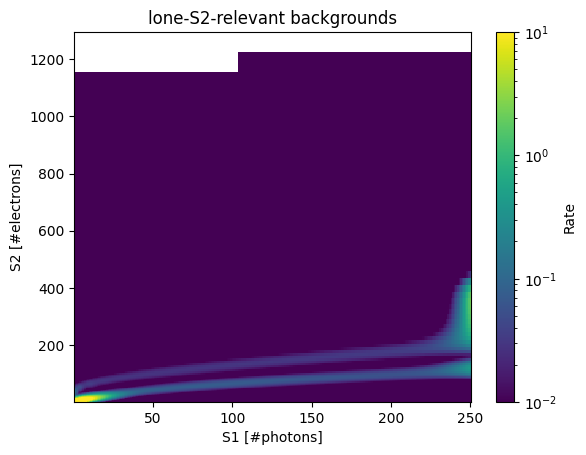

In [83]:
## Now convert those spectra to number-of-quanta space

S1q = []
S2q = []
Rq = []

    
binwidth = 0.25 # keV
''' We want finer binning than 1 keV, otherwise the spectra in 
    S1/S2 are not continuous. 
    '''
x_bg_l = np.linspace(0, energyRange, int(energyRange/binwidth))

#For the lone S1 signals:
def FillMatrix(a, b, c):
    S1q.append(a)
    S2q.append(b)
    Rq.append(c)

    
''' Get the central values for the number of S1 and S2 quanta produced. '''
for x in x_bg_l:
    if x < binwidth:
        continue
    a, b = detector.EnergyToQuanta(x,"ER")
    c = particleBackgrounds.BackgroundSpectraForLone(x, "S1", "ER")
    FillMatrix(a, b, c)
    ''' Due to the quenching, the ER and NR energy to quanta conversion
    is at different scales - at the same energy, NR produce less quanta
    and we have to include higher energies.'''
    a, b = detector.EnergyToQuanta(x*2.,"NR") 
    c = particleBackgrounds.BackgroundSpectraForLone(x*2., "S1", "NR")
    FillMatrix(a, b, c)    
''' Now we apply a gaussian smearing to recreate the statistical fluctuations in the 
    number of quanta produced. This does not take the anti-correlation into account. '''    
S1_forLS1, S2_forLS1, R_forLS1 = ACClasses.GaussianFilterGPT(Rq, S1q, S2q, binwidth, maxS1Range, maxS2Range, 0.2, detector.g2)

''' Make a nice plot '''
X_S1, Y_S2 = np.meshgrid(S1_forLS1, S2_forLS1)  
fig_xx, ax_xx = plt.subplots()    
max_val = np.max(R_forLS1[R_forLS1>0])
im_xx = ax_xx.pcolormesh(S1_forLS1, S2_forLS1, R_forLS1, norm=colors.LogNorm(vmin=1e-5,vmax=max_val))
ax_xx.set_xlabel("S1 [#photons]")
ax_xx.set_ylabel("S2 [#electrons]")
#ax_xx.set_ylim(0,950)
ax_xx.set_title("lone-S1-relevant backgrounds")
fig_xx.colorbar(im_xx, ax=ax_xx, pad=0.05, label="Rate")


S1q_2 = []
S2q_2 = []
Rq_2 = []

def FillMatrix_2(a, b, c):
    S1q_2.append(a)
    S2q_2.append(b)
    Rq_2.append(c)
#For the lone S2 signals:
for x in x_bg_l:
    if x < binwidth:
        continue
    a, b = detector.EnergyToQuanta(x,"ER")
    c = particleBackgrounds.BackgroundSpectraForLone(x, "S2", "ER")
    FillMatrix_2(a, b, c)
    a, b = detector.EnergyToQuanta(x*2.,"NR")
    c = particleBackgrounds.BackgroundSpectraForLone(x*2., "S2", "NR")
    FillMatrix_2(a, b, c) 

S1_forLS2, S2_forLS2, R_forLS2 = ACClasses.GaussianFilterGPT(Rq_2,S1q_2,S2q_2,binwidth, maxS1Range, maxS2Range, 0.2, detector.g2)



fig_xxx, ax_xxx = plt.subplots()   
ax_xxx.set_xlabel("S1 [#photons]")
ax_xxx.set_ylabel("S2 [#electrons]")
#ax_xxx.set_ylim(0,950)
ax_xxx.set_title("lone-S2-relevant backgrounds")
im_xxx = ax_xxx.pcolormesh(S1_forLS2, S2_forLS2,  R_forLS2,norm=colors.LogNorm(vmin=0.01,vmax=10)) 
fig_xx.colorbar(im_xxx, ax=ax_xxx, pad=0.05, label="Rate")

6070.46468942173, 5729.500817013424


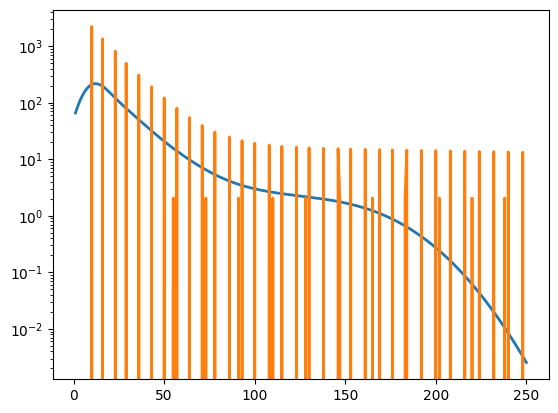

In [60]:
##Lone S1 from charge insensitive volume

S1only_FromCIV = np.arange(1, maxS1Range + 1, maxS1Range/250)


Rq_CIV = []
for x in S1only_FromCIV:
    Rq_CIV.append(0.0)
    
def FillCIV(x, R):
    PE = 0
    for i in S1only_FromCIV:
        if (abs(i-x) < 1):
            PE = int(i)
            break
    if (PE > 1):  #Otherwise, the number of PE created is out of range of the histogram
        index = int((PE - 1)*(250/maxS1Range)) 
        Rq_CIV[index] = Rq_CIV[index] + R     
for x in x_bg_l:

    if x < binwidth:
        continue
    a, b = detector.EnergyToQuanta(x,"ER")
    FillCIV(a+b, particleBackgrounds.BackgroundSpectrumFromCIV(x,"ER"))
    a, b = detector.EnergyToQuanta(x*2.,"NR")    
    FillCIV(a+b, particleBackgrounds.BackgroundSpectrumFromCIV(x,"NR"))

''' Now we apply a gaussian smearing to recreate the statistical fluctuations in the 
    number of quanta produced. This does not take the anti-correlation into account. '''    
R_LS1_ChargeIns = ACClasses.GaussianFilter1D(Rq_CIV, S1only_FromCIV, 1., maxS1Range, 1)

fig_bg3, ax_bg3 = plt.subplots()
ax_bg3.semilogy(S1only_FromCIV, R_LS1_ChargeIns, linewidth=2.0, label="Lone S1 from CIV")
ax_bg3.semilogy(S1only_FromCIV, Rq_CIV, linewidth=2.0, label="Lone S1 from CIV")



Text(0.5, 1.0, 'Rate of lone S1 from rad. backgrounds in active volume and in CIV')

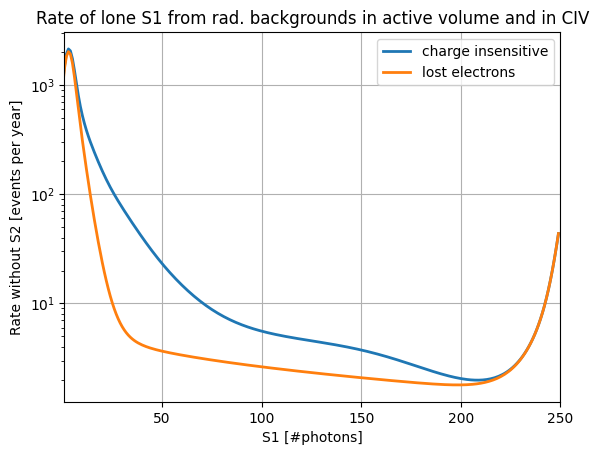

In [61]:
# Lone S1 from events where all e- are absorbed in active volume


R_LS1_Rad = []
R_LS1_RadChargeIns = [] # for the sum of the two components
x_LS1 = []
for i in range(len(R_forLS1)): # loop number of S1
    R_lost = 0.
    
    x_LS1.append(i)
    for j in range(len(R_forLS1[0])): #loop number of S2
        #Sample equally across length
        nsamples = 10
        for k in range(nsamples):
            R_lost = R_lost + R_forLS1[i,j]/nsamples*instrumentalBackgrounds.P_AllElectronsLost(j,k/nsamples * detector.MaxDriftTime)
    R_LS1_Rad.append(R_lost)
    R_LS1_RadChargeIns.append(R_lost+R_LS1_ChargeIns[i])
fig_noS2, ax_noS2 = plt.subplots()
ax_noS2.semilogy(x_LS1, R_LS1_RadChargeIns, linewidth=2.0, label="charge insensitive")
ax_noS2.semilogy(x_LS1, R_LS1_Rad, linewidth=2.0,  label="lost electrons")
ax_noS2.legend()
#ax_noS2.semilogy(x_LS1, R_LS1_ChargeIns, linewidth=2.0)
plt.xlim([1, 250])
ax_noS2.grid()
ax_noS2.set_xlabel("S1 [#photons]")
ax_noS2.set_ylabel("Rate without S2 [events per year]")
ax_noS2.set_title("Rate of lone S1 from rad. backgrounds in active volume and in CIV")     


# Something is terribly wrong in the next 2 plots !

In [62]:
# Turn the axis from 'quanta' to 'PE', and add DN

x_DN = np.linspace(1, 8, 8)
y_DNCoincidenceRate = instrumentalBackgrounds.DNCoincidenceRate(x_DN)

x_LS1_PE = []
R_LS1_FromCIV_PE = [] 
R_LS1_Rad_PE = [] 

# Apply g1; axis is in PE after this
# In principle, we also have to think about coincidences between DC pile-up and real light,
# but as long as the rates are this low, the chance of that is negligible

for i in range(1,round(len(R_LS1_Rad)*detector.g1)):
    R_LS1_FromCIV_PE.append(R_LS1_ChargeIns[round(i/detector.g1)])
    R_LS1_Rad_PE.append(R_LS1_Rad[round(i/detector.g1)])
    x_LS1_PE.append(i)



Text(0.5, 1.0, 'Rate of S2 from rad. backgrounds in active volume without S1')

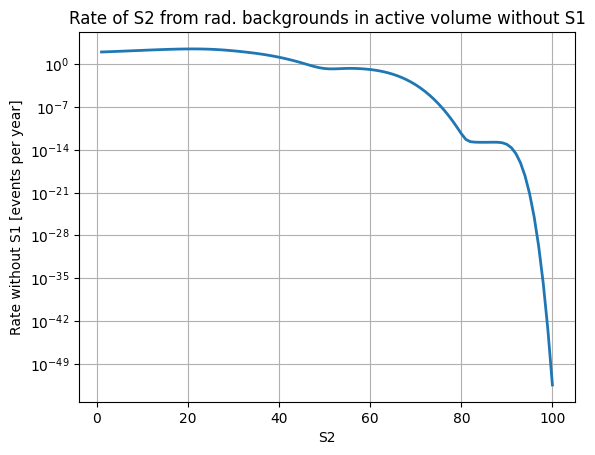

In [63]:
# Lone-S2  
#S1_2, S2_2, R_2, intrinsic only, since ext. events will be rejected from x-y position reconstruction based on S2 position
R_LS2 = []
x_LS2 = []
for j in range(1,len(R_forLS2[0])): # loop number of S2
    R_lost = 0.
    x_LS2.append(j)
    for i in range(1,len(R_forLS2)): #loop number of S1
        R_lost = R_lost + R_forLS2[i,j]*instrumentalBackgrounds.P_AllPhotonsLost(i,detector.height/2.) #Fixme, for now, all events produced in the center
    R_LS2.append(R_lost)
fig_noS1, ax_noS1 = plt.subplots()
ax_noS1.semilogy(x_LS2[0:100], R_LS2[0:100], linewidth=2.0)
ax_noS1.grid()
ax_noS1.set_xlabel("S2")
ax_noS1.set_ylabel("Rate without S1 [events per year]")
ax_noS1.set_title("Rate of S2 from rad. backgrounds in active volume without S1")

In [64]:
x_LS2_below_200 = [x for x in x_LS2 if x <= 200]
len_x_LS2_below_200 = len(x_LS2_below_200)
R_LS2_below_200 = R_LS2[0:len_x_LS2_below_200]

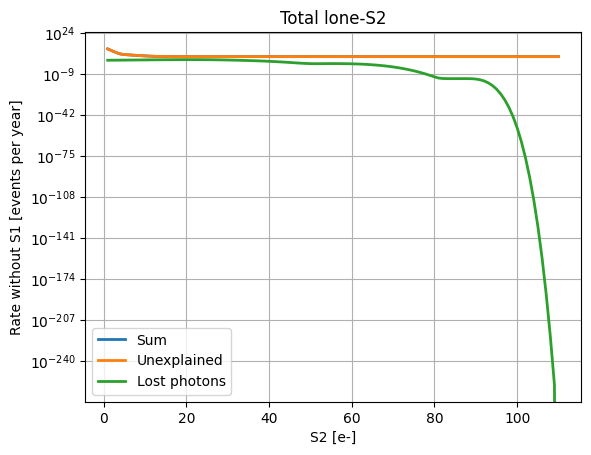

In [65]:
#Add lone-S2 unexplained

R_LS2_all = []
R_LS2_unexpl = []

for k, n in enumerate(x_LS2_below_200):
    Runexplained = instrumentalBackgrounds.RUnexplainedS2(n)
    #Runexplained=0
    R_LS2_unexpl.append(Runexplained)
    R_LS2_all.append( R_LS2[k] + Runexplained) 
fig_noS1tot, ax_noS1tot = plt.subplots()
ax_noS1tot.semilogy(x_LS2_below_200, R_LS2_all, linewidth=2.0, label="Sum")
ax_noS1tot.semilogy(x_LS2_below_200, R_LS2_unexpl, linewidth=2.0, label="Unexplained")
ax_noS1tot.semilogy(x_LS2_below_200, R_LS2_below_200, linewidth=2.0, label="Lost photons")



ax_noS1tot.grid()
ax_noS1tot.legend()

ax_noS1tot.set_xlabel("S2 [e-]")
ax_noS1tot.set_ylabel("Rate without S1 [events per year]")
ax_noS1tot.set_title("Total lone-S2")
plt.savefig("lone_S2.pdf", format="pdf",bbox_inches="tight")

#Added to convert electrons to PE
x_LS2_PE = []

x_LS2_PE = [x*detector.g2 for x in x_LS2_below_200]


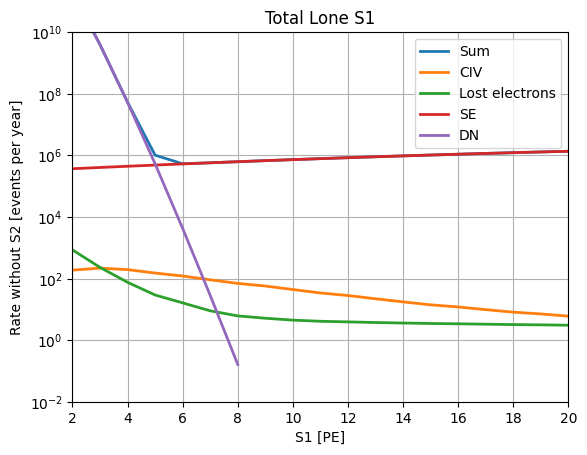

In [66]:
#Now add misclassified SE to S1 rate. 
# Single electrons are amplified given the SEgain.
# The SE gain spectrum is quite wide, so some fraction of them shows up at 
# much lower PE than they should and can be misclassified as an S1 with some probability.
R_LS1_all = []
R_LS1_SE = []


SErate = instrumentalBackgrounds.RUnexplainedS2(0)*instrumentalBackgrounds.S1MisclassificationProb 

for i in range(len(x_LS1_PE)):
    R_LS1_SE.append(0)
    R_LS1_all.append(0)

    R_LS1_SE[i] = SErate*instrumentalBackgrounds.SESpectrum(x_LS1_PE[i])
    R_LS1_all[i] = R_LS1_SE[i] + R_LS1_FromCIV_PE[i] + R_LS1_Rad_PE[i]

    if i < len(y_DNCoincidenceRate):
        R_LS1_all[i] = R_LS1_all[i] + y_DNCoincidenceRate[i]


fig_noS2total, ax_noS2total = plt.subplots()
ax_noS2total.semilogy(x_LS1_PE, R_LS1_all, linewidth=2.0, label="Sum")
ax_noS2total.semilogy(x_LS1_PE, R_LS1_FromCIV_PE, linewidth=2.0, label="CIV")
ax_noS2total.semilogy(x_LS1_PE, R_LS1_Rad_PE, linewidth=2.0, label="Lost electrons")
ax_noS2total.semilogy(x_LS1_PE, R_LS1_SE, linewidth=2.0, label="SE")
ax_noS2total.semilogy(x_DN, y_DNCoincidenceRate, linewidth=2.0, label="DN")
ax_noS2total.grid()
plt.xlim([2, 20]) 
plt.ylim([1e-2, 1e10]) 
ax_noS2total.legend(loc='upper right')
ax_noS2total.set_xlabel("S1 [PE]")
ax_noS2total.set_ylabel("Rate without S2 [events per year]")
ax_noS2total.set_title("Total Lone S1")   
plt.savefig("lone_S1.pdf", format="pdf",bbox_inches="tight")
#for i in range(4):
    #print (str(i) + ": " + str(x_LS1_PE[i]) + ", " + str(R_LS1_all[i]))

* This is not the template, it's just a heat map to visualise things that's all !

rate in red box is 19337.4198 events/tonne year


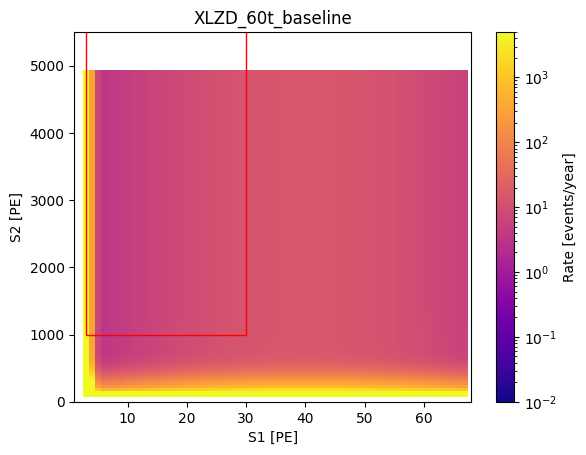

In [67]:
# Mixing them up
## 
## Lone-S1: x_LS1_PE, R_LS1_all
## Lone-S2: x_LS2, R_LS2_all
X_mix, Y_mix = np.meshgrid(x_LS1_PE, x_LS2_PE)
Z_ACPDF = np.eye(len(x_LS2_PE),len(x_LS1_PE))
for i in range(len(R_LS1_all)):
    for j in range(len(R_LS2_all)):
        if (i <=1 or j==0):Z_ACPDF[j,i] = 0.0 #For 'i+2'-fold coincidence, make i=1 for 3 fold ?
        else: Z_ACPDF[j,i] =  R_LS1_all[i]*R_LS2_all[j]*detector.MaxDriftTime*1./ACClasses.SecondsPerYear*1e-9
        #note inverted "i,j" due to weird axis definitions in np.meshgrid


#ens = [1., 2.] 
#yrange=(1,300)


fig_mix, ax_mix = plt.subplots()
levels = np.ndarray((5,), buffer=np.array([1e-10, 1e-8, 1e-6, 1e-4, 1e-2]))
plt.xlim([1., 68]) 
plt.ylim([0, 5500]) 
im = ax_mix.pcolormesh(X_mix, Y_mix, Z_ACPDF, norm=colors.LogNorm(vmin=1e-2, vmax=5e3), cmap='plasma')
ax_mix.set_ylabel("S2 [PE]")
#ax_mix.set_ylim(50,1000)
#ax_mix.set_xlim(20,60)
ax_mix.set_xlabel("S1 [PE]")

ax_mix.set_title("XLZD_60t_baseline")
fig_mix.colorbar(im, ax=ax_mix, label="Rate [events/year]")

#calculate rate in a box
xmin = 3
xmax = 30
ymin = 1000
ymax = 100000

rect = patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='r', facecolor='none')
ax_mix.add_patch(rect)
totalrate = 0.0
for i in range(len(X_mix[0])):
    for j in range(len(Y_mix[1])):
        if (X_mix[0][i] >= xmin and X_mix[0][i] < xmax):
            if (Y_mix[j,i] >= ymin and Y_mix[j,i] < ymax):
                #print("x:" + str (X_mix[0][i]) + ", y:" + str(Y_mix[j,i]) + " :" + str(Z_mix[j,i]))
                totalrate = totalrate + Z_ACPDF[j,i]

print("rate in red box is " + "{:.4f}".format(totalrate/60) + " events/tonne year")
plt.savefig("AC_S1S2.pdf", format="pdf",bbox_inches="tight")
Z_ACPDF_transpose= np.transpose(Z_ACPDF) #To convert it since it was filled like Z_ACPDF[j,i] and not Z_ACPDF[i, j], have to transpose it

In [86]:
print(Z_ACPDF_transpose)
print(np.shape(Z_ACPDF_transpose))
print((Z_ACPDF_transpose).ndim)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.43315178e+09 5.44611750e+07 ... 2.52312371e+04
  2.52312371e+04 2.52312371e+04]
 ...
 [0.00000000e+00 3.71404513e+05 1.41137362e+04 ... 6.53873194e+00
  6.53873194e+00 6.53873194e+00]
 [0.00000000e+00 3.48468482e+05 1.32421445e+04 ... 6.13493352e+00
  6.13493352e+00 6.13493352e+00]
 [0.00000000e+00 3.26138054e+05 1.23935663e+04 ... 5.74179698e+00
  5.74179698e+00 5.74179698e+00]]
(67, 100)
2


In [68]:
print(np.shape(Z_ACPDF_transpose))
Z_ACPDF_transpose=Z_ACPDF_transpose[:,:100]
print(np.shape(Z_ACPDF_transpose))

(67, 110)
(67, 100)


In [69]:
print(Z_ACPDF_transpose)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.43315178e+09 5.44611750e+07 ... 2.52312371e+04
  2.52312371e+04 2.52312371e+04]
 ...
 [0.00000000e+00 3.71404513e+05 1.41137362e+04 ... 6.53873194e+00
  6.53873194e+00 6.53873194e+00]
 [0.00000000e+00 3.48468482e+05 1.32421445e+04 ... 6.13493352e+00
  6.13493352e+00 6.13493352e+00]
 [0.00000000e+00 3.26138054e+05 1.23935663e+04 ... 5.74179698e+00
  5.74179698e+00 5.74179698e+00]]


# AC Template 

Confirm the bin params with Pranati !

New binning version..but it doesn't change anything...the reason we chose new binning was to take all the columns above (al 110 instead of 100), but this meant changing the binning to 120, this causes an issue in flamefitsimple !

In [70]:
"""
#S1_bin = np.linspace(0.0, 150.0, 151)# Change binning for XLZD
S1_bin = np.linspace(1.5, 30, 120)
#S2_bin = np.logspace(2,4.75, 110+1)  
S2_bin = np.logspace(2.5,5, 119+1)      
S1_mix,S2_mix = np.meshgrid(S1_bin, S2_bin)

extended_Z_ACPDF = np.zeros((120, 120)) # I'm guessing for XLZD it would be (101,101) as we 100x100 binning? ..may have to change binnning to 120 ,120
extended_Z_ACPDF[:67,:110] = Z_ACPDF_transpose # it's dimensions of z transpose array 

Z_ACPDF_final = []
for i in range(len(extended_Z_ACPDF)-1):
    for j in range(len(extended_Z_ACPDF[0])-1):
        avg = (extended_Z_ACPDF[i, j] + extended_Z_ACPDF[i, j+1] + extended_Z_ACPDF[i+1, j] + extended_Z_ACPDF[i+1, j+1])*0.25
        Z_ACPDF_final.append(avg)
Z_ACPDF_final = np.array(Z_ACPDF_final)
print(np.shape(Z_ACPDF_final))
Z_ACPDF_final = np.reshape(Z_ACPDF_final, (119, 119)) # I'm guessing (100,100) here for XLZD
"""

"\n#S1_bin = np.linspace(0.0, 150.0, 151)# Change binning for XLZD\nS1_bin = np.linspace(1.5, 30, 120)\n#S2_bin = np.logspace(2,4.75, 110+1)  \nS2_bin = np.logspace(2.5,5, 119+1)      \nS1_mix,S2_mix = np.meshgrid(S1_bin, S2_bin)\n\nextended_Z_ACPDF = np.zeros((120, 120)) # I'm guessing for XLZD it would be (101,101) as we 100x100 binning? ..may have to change binnning to 120 ,120\nextended_Z_ACPDF[:67,:110] = Z_ACPDF_transpose # it's dimensions of z transpose array \n\nZ_ACPDF_final = []\nfor i in range(len(extended_Z_ACPDF)-1):\n    for j in range(len(extended_Z_ACPDF[0])-1):\n        avg = (extended_Z_ACPDF[i, j] + extended_Z_ACPDF[i, j+1] + extended_Z_ACPDF[i+1, j] + extended_Z_ACPDF[i+1, j+1])*0.25\n        Z_ACPDF_final.append(avg)\nZ_ACPDF_final = np.array(Z_ACPDF_final)\nprint(np.shape(Z_ACPDF_final))\nZ_ACPDF_final = np.reshape(Z_ACPDF_final, (119, 119)) # I'm guessing (100,100) here for XLZD\n"

# Flamedisx Binning 

In [71]:
#S1_bin = np.linspace(0.0, 150.0, 151)# Change binning for XLZD
S1_bin = np.linspace(3, 30, 101)
#S2_bin = np.logspace(2,4.75, 110+1)  
S2_bin = np.logspace(3,5, 100+1)      
S1_mix,S2_mix = np.meshgrid(S1_bin, S2_bin)

extended_Z_ACPDF = np.zeros((101, 101)) # I'm guessing for XLZD it would be (101,101) as we 100x100 binning? ..may have to change binnning to 120 ,120
extended_Z_ACPDF[:67,:100] = Z_ACPDF_transpose # it's dimensions of z transpose array 

Z_ACPDF_final = []
for i in range(len(extended_Z_ACPDF)-1):
    for j in range(len(extended_Z_ACPDF[0])-1):
        avg = (extended_Z_ACPDF[i, j] + extended_Z_ACPDF[i, j+1] + extended_Z_ACPDF[i+1, j] + extended_Z_ACPDF[i+1, j+1])*0.25
        Z_ACPDF_final.append(avg)
Z_ACPDF_final = np.array(Z_ACPDF_final)
print(np.shape(Z_ACPDF_final))
Z_ACPDF_final = np.reshape(Z_ACPDF_final, (100, 100)) # I'm guessing (100,100) here for XLZD

(10000,)


CHopping Range 

In [72]:
"""
#S1_bin = np.linspace(0.0, 150.0, 151)# Change binning for XLZD
S1_bin = np.linspace(1.5, 7.07, 101)
#S2_bin = np.logspace(2,4.75, 110+1)  
S2_bin = np.logspace(3.3,3.7, 100+1)      
S1_mix,S2_mix = np.meshgrid(S1_bin, S2_bin)

extended_Z_ACPDF = np.zeros((101, 101)) # I'm guessing for XLZD it would be (101,101) as we 100x100 binning? ..may have to change binnning to 120 ,120
extended_Z_ACPDF[:67,:100] = Z_ACPDF_transpose # it's dimensions of z transpose array 

Z_ACPDF_final = []
for i in range(len(extended_Z_ACPDF)-1):
    for j in range(len(extended_Z_ACPDF[0])-1):
        avg = (extended_Z_ACPDF[i, j] + extended_Z_ACPDF[i, j+1] + extended_Z_ACPDF[i+1, j] + extended_Z_ACPDF[i+1, j+1])*0.25
        Z_ACPDF_final.append(avg)
Z_ACPDF_final = np.array(Z_ACPDF_final)
print(np.shape(Z_ACPDF_final))
Z_ACPDF_final = np.reshape(Z_ACPDF_final, (100, 100)) # I'm guessing (100,100) here for XLZD
"""

"\n#S1_bin = np.linspace(0.0, 150.0, 151)# Change binning for XLZD\nS1_bin = np.linspace(1.5, 7.07, 101)\n#S2_bin = np.logspace(2,4.75, 110+1)  \nS2_bin = np.logspace(3.3,3.7, 100+1)      \nS1_mix,S2_mix = np.meshgrid(S1_bin, S2_bin)\n\nextended_Z_ACPDF = np.zeros((101, 101)) # I'm guessing for XLZD it would be (101,101) as we 100x100 binning? ..may have to change binnning to 120 ,120\nextended_Z_ACPDF[:67,:100] = Z_ACPDF_transpose # it's dimensions of z transpose array \n\nZ_ACPDF_final = []\nfor i in range(len(extended_Z_ACPDF)-1):\n    for j in range(len(extended_Z_ACPDF[0])-1):\n        avg = (extended_Z_ACPDF[i, j] + extended_Z_ACPDF[i, j+1] + extended_Z_ACPDF[i+1, j] + extended_Z_ACPDF[i+1, j+1])*0.25\n        Z_ACPDF_final.append(avg)\nZ_ACPDF_final = np.array(Z_ACPDF_final)\nprint(np.shape(Z_ACPDF_final))\nZ_ACPDF_final = np.reshape(Z_ACPDF_final, (100, 100)) # I'm guessing (100,100) here for XLZD\n"

# Making and visualizing the template 

In [73]:
#Convert to template for binference
trigger="n4tw200" 
field = detector.DriftField
version = "v0.1.0"
binf_folder = f"XLZD_base_binf_{trigger}_{field}Vcm_{version}"
binf_comp = 'AC'
if not os.path.isdir(binf_folder):
    yes_answer = {'yes','y', 'ye', ''}
    if input("Create directory? ").lower() in yes_answer:
        os.makedirs(binf_folder)
helpers.numpy_to_template(
    bins=[S1_bin, np.log10(S2_bin)], 
    histograms=[Z_ACPDF_final/detector.fiducialMass], 
    file_name= os.path.join(binf_folder, binf_comp+'_XLZDTemplate_3fold_latest_chop.hdf'), 
    histogram_names = ['hmc'], 
    axis_names = ['cS1', 'log10_cS2'],
    metadata={"version":"0.1.0",
                "date":datetime.now().strftime('%Y%m%d_%H:%M:%S'),
                "field":field,
                "s1trigger":trigger
                }
    )


file f opened, 1st time,  []
writing histogram name hmc


In [74]:
import h5py

file_path ="/Users/amirr/Desktop/AC_backgrounds_pdfs/XLZD_base_binf_n4tw200_200Vcm_v0.1.0/AC_XLZDTemplate_3fold_latest_chop.hdf"


with h5py.File(file_path, 'r') as hdf:

    print("Keys in the HDF file:", list(hdf.keys()))
    
    bins_data = hdf.get('bins')
    bins_data=np.array(bins_data)
    print("'bins' shape:", bins_data.shape)
    print(bins_data)
    

    templates_data = hdf.get('templates')
    templates_data=np.array(templates_data)
    print("'templates' shape:", templates_data.shape)
    print(templates_data)
# Will run this after confirming the params 

Keys in the HDF file: ['bins', 'templates']
'bins' shape: (2,)
['0' '1']
'templates' shape: (1,)
['hmc']


Need this function from XENON Collob to make the hmc into a multi hist object 

28699542.069784444


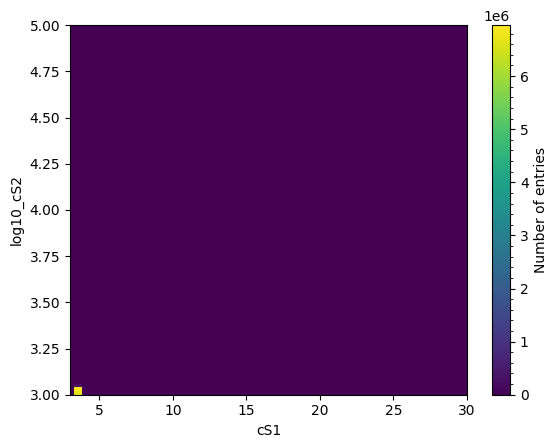

In [75]:
import inference_interface
import matplotlib as mpl

AC_temp=inference_interface.template_to_multihist(file_path)['hmc']
AC_temp.plot() # This should output the AC template
print(AC_temp.n)


In [76]:
a=AC_temp.bin_volumes()
print(a.shape)

(100, 100)


In [77]:
print(len(AC_temp.bin_edges[0]))
print(len(AC_temp.bin_edges[1]))

101
101


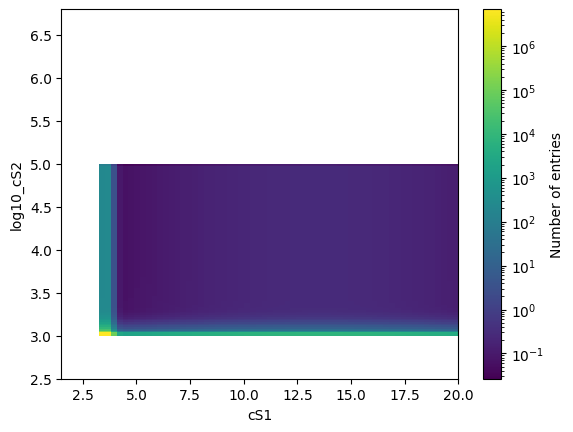

In [78]:
# For aesthetic purposes : 
import matplotlib.pyplot as plt
from matplotlib import gridspec
AC_temp.plot(norm=mpl.colors.LogNorm())
plt.xlim(1.5,20) 
plt.ylim(2.5,6.80)
plt.show()
#Zoomed Out version 


Shape of bin_centers_cS1: (100,)
Shape of counts_cS1: (100,)


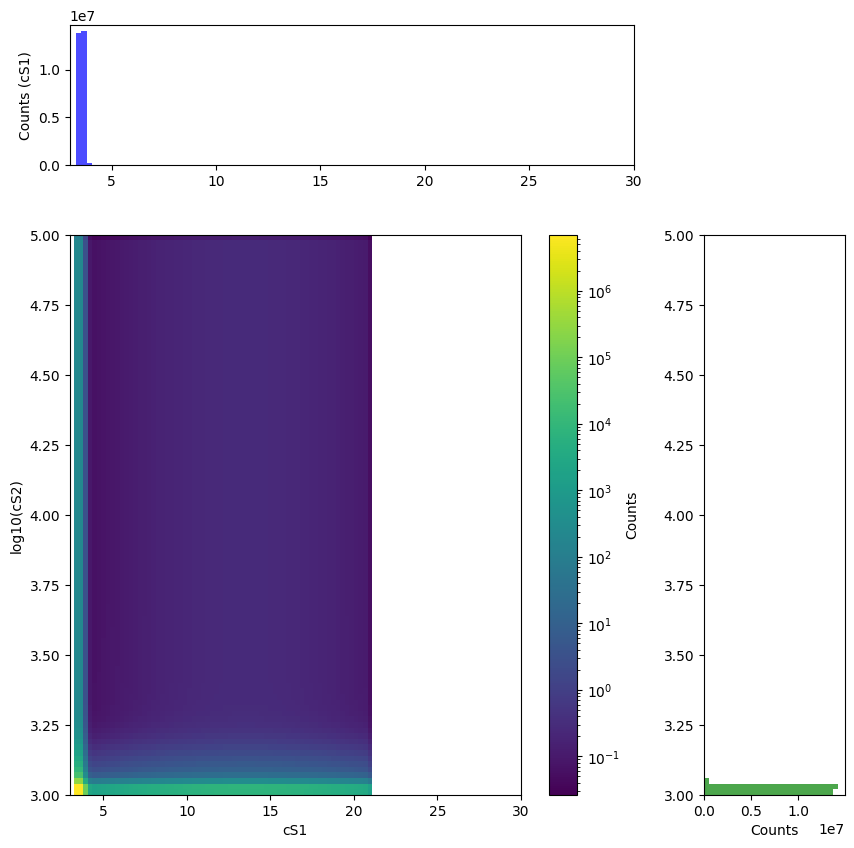

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Assume AC_temp is already defined
bin_edges_cS1 = AC_temp.bin_edges[0]  # Bin edges for 'cS1'
bin_edges_cS2 = AC_temp.bin_edges[1]  # Bin edges for 'log10_cS2
bin_centers_cS1 = (bin_edges_cS1[:-1] + bin_edges_cS1[1:]) / 2
bin_centers_cS2 = (bin_edges_cS2[:-1] + bin_edges_cS2[1:]) / 2

# Get histogram counts
counts_cS1 = AC_temp.histogram.sum(axis=1) # Sum over 'log10_cS2'
counts_cS2 = AC_temp.histogram.sum(axis=0) # Sum over 'cS1'

print(f"Shape of bin_centers_cS1: {bin_centers_cS1.shape}")
print(f"Shape of counts_cS1: {counts_cS1.shape}")

# Main 2D histogram (joint distribution)
main_histogram = AC_temp.histogram.T  # Transpose for proper alignment

# Create a figure with gridspec layout
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(4, 4, wspace=.5, hspace=.5)

# Main plot (joint distribution)
ax_main = fig.add_subplot(gs[1:, :-1])
pcm = ax_main.pcolormesh(bin_edges_cS1, bin_edges_cS2, main_histogram,cmap='viridis',norm=mcolors.LogNorm())
ax_main.set_xlabel('cS1')
ax_main.set_ylabel('log10(cS2)')
fig.colorbar(pcm, ax=ax_main, label='Counts')

# Top histogram (cS1)
ax_top = fig.add_subplot(gs[0, :-1], sharex=ax_main)
ax_top.bar(bin_centers_cS1, counts_cS1, width=np.diff(bin_edges_cS1), align='center', color='blue', alpha=0.7)
ax_top.set_ylabel('Counts (cS1)')
ax_top.tick_params(axis='x', labelbottom=True)

# Right histogram (cS2)
ax_right = fig.add_subplot(gs[1:, -1], sharey=ax_main)
ax_right.barh(bin_centers_cS2, counts_cS2, height=np.diff(bin_edges_cS2), align='center', color='green', alpha=0.7)
ax_right.set_xlabel('Counts')
ax_right.tick_params(axis='y', labelleft=True)

# Show the plot
plt.show()


# How scaling works

Essentially the AC rates scale with fid mass (relation below) and depending on the proportionality constant we can scale to any desired F.mass.
# The relation is following 

R_ac=axm^3*(np.exp(-m**(2/3)))
>Where "a" is known a-priori for a given fid mass of a given detector as from data driven models we know the expected AC rate for them and m is the fid mass 
* For XENON1t it is a_1t=0.9
* For XENONnt it is a_nt=2.9
* For LZ it is a_LZ=1.0

[ 0 10 20 30 40 50 60 70 80]
[0.00000000e+00 8.67812880e+00 4.54384381e+00 1.55789848e+00
 4.79604676e-01 1.43505835e-01 4.29157891e-02 1.29732295e-02
 3.98333470e-03]


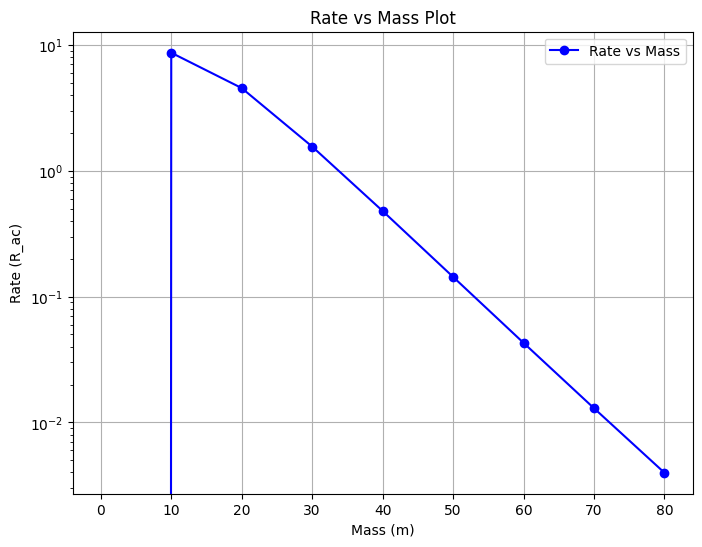

In [80]:
import numpy as np

a = 0.9  # Define 'a' appropriately
m = np.arange(0,90,10)
print(m)
R_ac = []

for i in m:
    R_ac.append(a * i**3 * np.exp(-i**(2/3)))

R_ac = np.array(R_ac)#*365.*24.*60.*60.

print(R_ac)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(m, R_ac, marker='o', linestyle='-', color='b', label='Rate vs Mass')

# Labels and title
plt.xlabel("Mass (m)")
plt.ylabel("Rate (R_ac)")
plt.yscale("log")
plt.title("Rate vs Mass Plot")
plt.legend()
plt.grid()

# Show the plot
plt.show()


# Variation of AC rates with drift field 

* AC Rates depend on drift field via : 
* Empirically, R-AC~$T_d$ (Drift time) and $T_d$ is related to $a/np.power(DriftField,b)$
a,b are coming from fit
* MaxDriftTime = TPCHeight/Electron_Drift_speed 

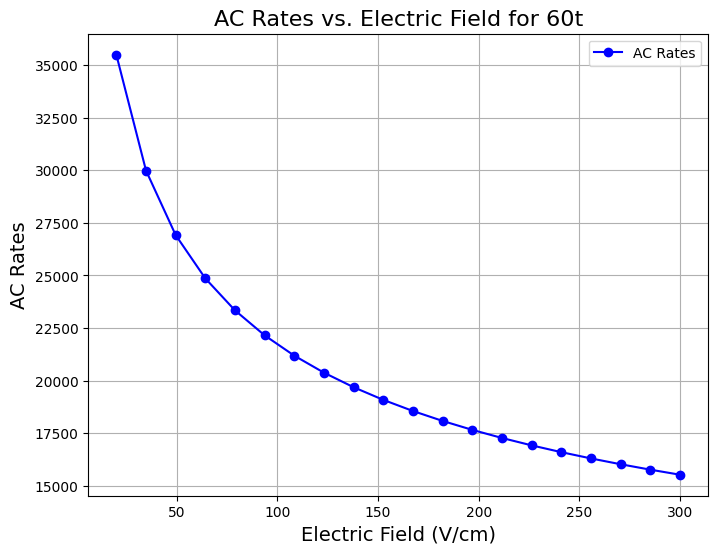

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Constants for electron drift speed calculation
a = 0.2459
b = -0.30527

# Function for Electron Drift Speed (in mm/us)
def fElectronDriftSpeed(DriftField):
    return a / np.power(DriftField, b)

# Convert speed from mm/us to cm/ns
def convert_to_cm_ns(drift_speed):
    return drift_speed / 1e4  # Convert mm/µs to cm/ns

# Define Electric Field range (V/cm)
E_fields = np.linspace(20, 300, 20) 

# Compute Electron Drift Speed
Electron_Drift_speeds = convert_to_cm_ns(fElectronDriftSpeed(E_fields))

TPCHeight = 298  # in cm

# Compute Max Drift Time (T_d = TPCHeight / Drift Speed)
T_d = TPCHeight / Electron_Drift_speeds  # ns

# Assume AC Rates are proportional to T_d (empirical)
k=0.6
m=60 #tonnes
R_AC = k*T_d *(m**(8/3)*np.exp(-m**(2/3)))

# Plot AC Rates vs. Electric Field
plt.figure(figsize=(8, 6))
plt.plot(E_fields, R_AC, color='b', linestyle='-', marker='o', label='AC Rates')

# Labels and title 
plt.xlabel("Electric Field (V/cm)", fontsize=14)
plt.ylabel("AC Rates", fontsize=14)
plt.title("AC Rates vs. Electric Field for 60t", fontsize=16)
plt.grid(True)
plt.legend()
plt.show()

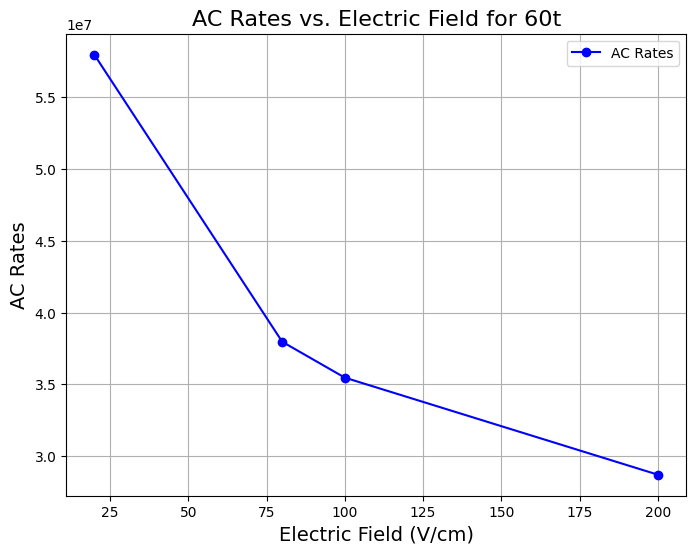

In [82]:
import numpy as np
import matplotlib.pyplot as plt
E_fields=[20,80,100,200]
R_ac=[57962210.5652,37962438.6089,35462584.6580,28699542.0697]


# Plot AC Rates vs. Electric Field
plt.figure(figsize=(8, 6))
plt.plot(E_fields, R_ac, color='b', linestyle='-', marker='o', label='AC Rates')

# Labels and title 
plt.xlabel("Electric Field (V/cm)", fontsize=14)
plt.ylabel("AC Rates", fontsize=14)
plt.title("AC Rates vs. Electric Field for 60t", fontsize=16)
plt.grid(True)
plt.legend()
plt.show()